# Direct Access to Seismological Data using Python and ObsPy

This is a very short attempt at looking at a Python conversion of
[this MATLAB Central post](http://blogs.mathworks.com/loren/2015/03/03/direct-access-to-seismological-data-using-matlab/).
I won't be converting the text and explanations; just trying out the examples.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 8

## Examples

The [ObsPy package](https://www.obspy.org/) contains several methods that can used to retrieve
station metadata, time series, or event information from FDSN servers. They are the
[`get_stations`](https://docs.obspy.org/packages/autogen/obspy.fdsn.client.Client.get_stations.html#obspy.fdsn.client.Client.get_stations),
[`get_waveforms`](https://docs.obspy.org/packages/autogen/obspy.fdsn.client.Client.get_waveforms.html#obspy.fdsn.client.Client.get_waveforms) and
[`get_events`](https://docs.obspy.org/packages/autogen/obspy.fdsn.client.Client.get_events.html#obspy.fdsn.client.Client.get_events) methods of the
[`obspy.fdsn.Client`](https://docs.obspy.org/packages/autogen/obspy.fdsn.client.Client.html#obspy.fdsn.client.Client)
class. Below are some examples of how each of these components can be used for common data retrieval tasks.

In [2]:
from obspy import UTCDateTime
from obspy.fdsn import Client

client = Client('IRIS', debug=True)

Base URL: http://service.iris.edu
Request Headers: {'User-Agent': 'ObsPy 0.10.2 (Linux-3.19.7-200.fc21.x86_64-x86_64-with-fedora-21-Twenty_One, Python 3.4.1)'}
Downloaded http://service.iris.edu/fdsnws/event/1/catalogs with HTTP code: 200
Downloaded http://service.iris.edu/fdsnws/event/1/contributors with HTTP code: 200
Downloaded http://service.iris.edu/fdsnws/dataselect/1/application.wadl with HTTP code: 200
Downloaded http://service.iris.edu/fdsnws/event/1/application.wadl with HTTP code: 200
Downloaded http://service.iris.edu/fdsnws/station/1/application.wadl with HTTP code: 200
Discovered dataselect service
Discovered event service
Discovered station service
Storing discovered services in cache.


### Example 1

Plot time series for the 2011 Tohoku-Oki earthquake. The following example uses
[`get_waveforms`](https://docs.obspy.org/packages/autogen/obspy.fdsn.client.Client.get_waveforms.html#obspy.fdsn.client.Client.get_waveforms)
to retrieve time series data for global GSN stations to plot 1 hour of data (bandpass
filtered from 1 - 5 Hz) following the Tohoku-Oni earthquake of March 2011.

In [3]:
start = UTCDateTime('2011-03-11T15:10:00')
end = UTCDateTime('2011-03-11T16:10:00')

tohoku_tr = client.get_waveforms(network='_GSN', station='MAJO,WMQ,KAPI,CMB',
                                 location='00', channel='BHZ',
                                 starttime=start, endtime=end)

Downloaded http://service.iris.edu/fdsnws/dataselect/1/query?endtime=2011-03-11T16%3A10%3A00.000000&network=_GSN&starttime=2011-03-11T15%3A10%3A00.000000&channel=BHZ&location=00&station=MAJO%2CWMQ%2CKAPI%2CCMB with HTTP code: 200


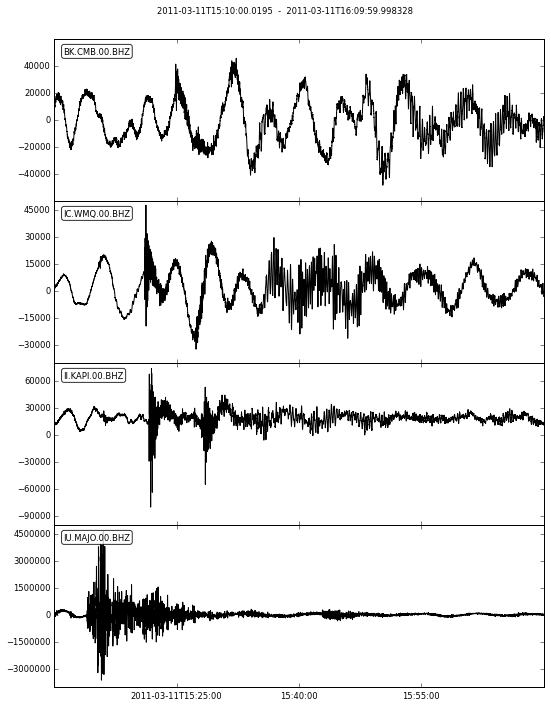

In [4]:
tohoku_tr.plot(equal_scale=False)

set filter parameters

In [5]:
bandfilt_freq1 = 1
bandfilt_freq2 = 5
bandfilt_order = 4

In [6]:
tohoku_filt = tohoku_tr.filter(type='bandstop', freqmin=bandfilt_freq1, freqmax=bandfilt_freq2, corners=bandfilt_order)

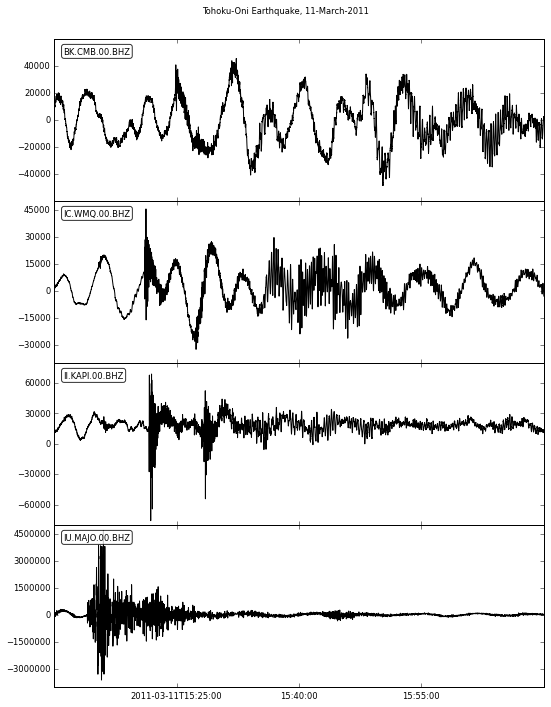

In [7]:
tohoku_filt.label = 'Tohoku-Oni Earthquake, 11-March-2011'
tohoku_filt.plot(equal_scale=False)

### Example 2

Plot a map of Transportable Array (TA) network stations and recent earthquakes
in Oklahoma. This example uses
[`get_events`](https://docs.obspy.org/packages/autogen/obspy.fdsn.client.Client.get_events.html#obspy.fdsn.client.Client.get_events) and
[`get_stations`](https://docs.obspy.org/packages/autogen/obspy.fdsn.client.Client.get_stations.html#obspy.fdsn.client.Client.get_stations)
to retrieve hypocenter data and station metadata, respectively, to make a simple plot.

In [8]:
minlat = 35
maxlat = 37.5

minlon = -100
maxlon = -95

starttime = UTCDateTime('2012-01-01T00:00:00')
endtime = UTCDateTime('2015-02-01T00:00:00')

minmag = 0.0
maxmag = 4.0

ok_ev = client.get_events(minlatitude=minlat, maxlatitude=maxlat,
                          minlongitude=minlon, maxlongitude=maxlon,
                          minmagnitude=minmag, maxmagnitude=maxmag,
                          starttime=starttime, endtime=endtime)

ok_sta = client.get_stations(network='TA', channel='BH?',
                             minlatitude=minlat, maxlatitude=maxlat,
                             minlongitude=minlon, maxlongitude=maxlon)

title = 'M<%d -- %s to %s -- %d total events' % (
    maxmag,
    starttime,
    endtime,
    len(ok_ev))

Downloaded http://service.iris.edu/fdsnws/event/1/query?endtime=2015-02-01T00%3A00%3A00.000000&minlongitude=-100.0&minmagnitude=0.0&maxlatitude=37.5&maxmagnitude=4.0&starttime=2012-01-01T00%3A00%3A00.000000&minlatitude=35.0&maxlongitude=-95.0 with HTTP code: 200
Downloaded http://service.iris.edu/fdsnws/station/1/query?minlongitude=-100.0&maxlatitude=37.5&network=TA&minlatitude=35.0&channel=BH%3F&maxlongitude=-95.0 with HTTP code: 200


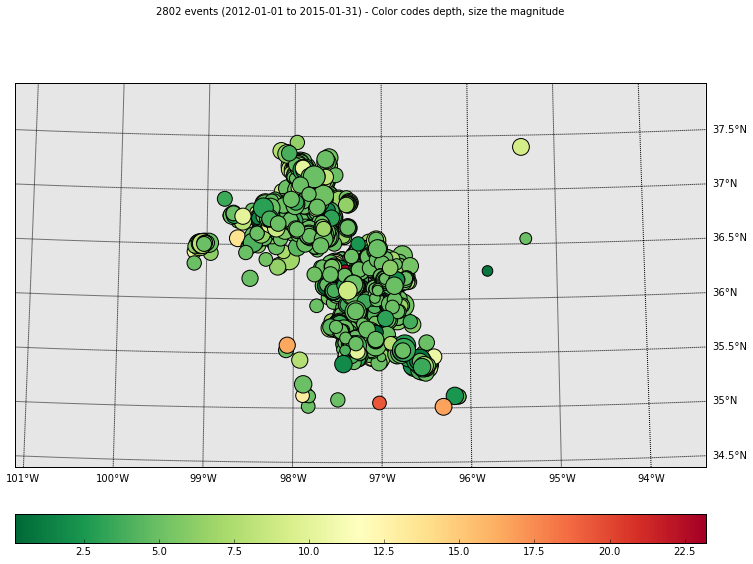

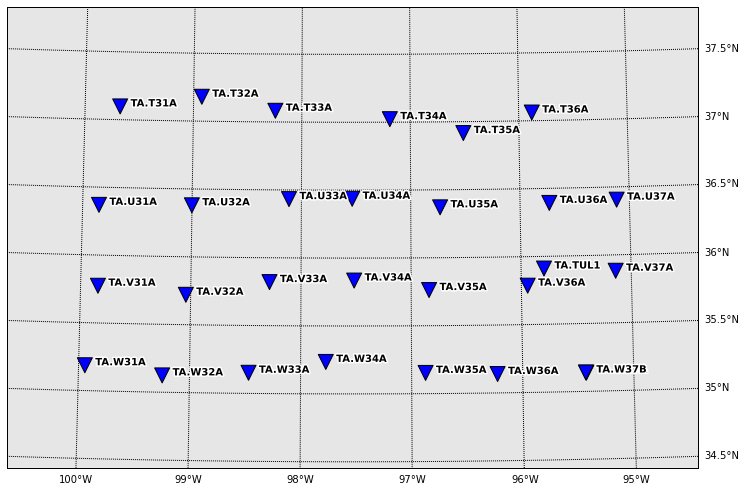

In [9]:
fig = ok_ev.plot(projection='local')
fig = ok_sta.plot(projection='local')

Unfortunately, we cannot use ObsPy directly to plot both events and stations on the same
plot. We must instead use Python and matplotlib's map plotting functionality directly.
Fortunately, it is not too difficult to achieve.

Simply create a plot with the desired projection, and draw a scatter of the points as
done usually.

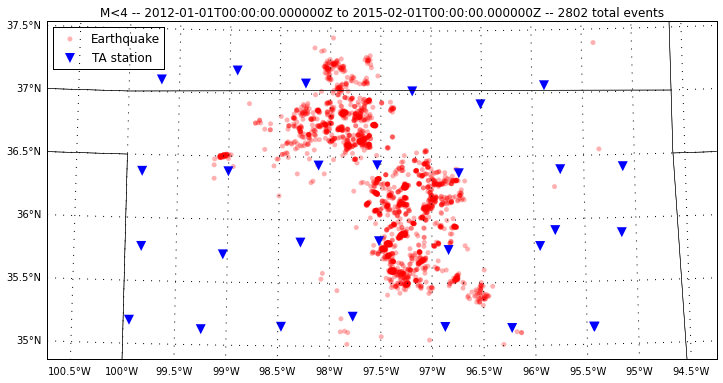

In [10]:
from mpl_toolkits.basemap import Basemap
from obspy.core.util import degrees2kilometers

ev_lat = [ev.preferred_origin().latitude for ev in ok_ev]
ev_lon = [ev.preferred_origin().longitude for ev in ok_ev]
sta_lat = [sta.latitude for net in ok_sta for sta in net]
sta_lon = [sta.longitude for net in ok_sta for sta in net]

lon = np.array(ev_lon + sta_lon)
lat = np.array(ev_lat + sta_lat)
avg_lon = np.mean(lon)
avg_lat = np.mean(lat)
width = 1.1e3 * degrees2kilometers(np.max(lon) - np.min(lon))
height = 1.1e3 * degrees2kilometers(np.max(lat) - np.min(lat))

bm = Basemap(projection='aea',
             lon_0=avg_lon, lat_0=avg_lat, width=width, height=height)
bm.drawstates()
parallels = np.arange(int(bm.llcrnrlat), int(bm.urcrnrlat) + 1, 0.5)
bm.drawparallels(parallels, labels=[1,0,0,0], fontsize=10, dashes=[1, 7])
meridians = np.arange(int(bm.llcrnrlon) - 1, int(bm.urcrnrlon), 0.5)
bm.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10, dashes=[1, 7])

bm.scatter(np.array(ev_lon), np.array(ev_lat), latlon=True,
           s=100, c='r', alpha=0.3, edgecolor='none', marker='.',
           label='Earthquake')
bm.scatter(np.array(sta_lon), np.array(sta_lat), latlon=True,
           s=100, c='b', edgecolor='none', marker='v',
           label='TA station')

plt.legend(loc='upper left', scatterpoints=1)
plt.title(title)

### Example 3

Retrieving data from other datacenters. The versatility of the `obspy.fdsn` methods
allow users to access data from web services hosted by other datacenters, as long as
they conform to the specification set by the FDSN. This example uses data obtained
from the USGS fdsn-event service.

In [11]:
usgs = Client('USGS')

minmag_glob = 6
tstart = UTCDateTime('2000-01-01T00:00:00')
glob_ev = usgs.get_events(starttime=tstart, minmagnitude=minmag_glob)

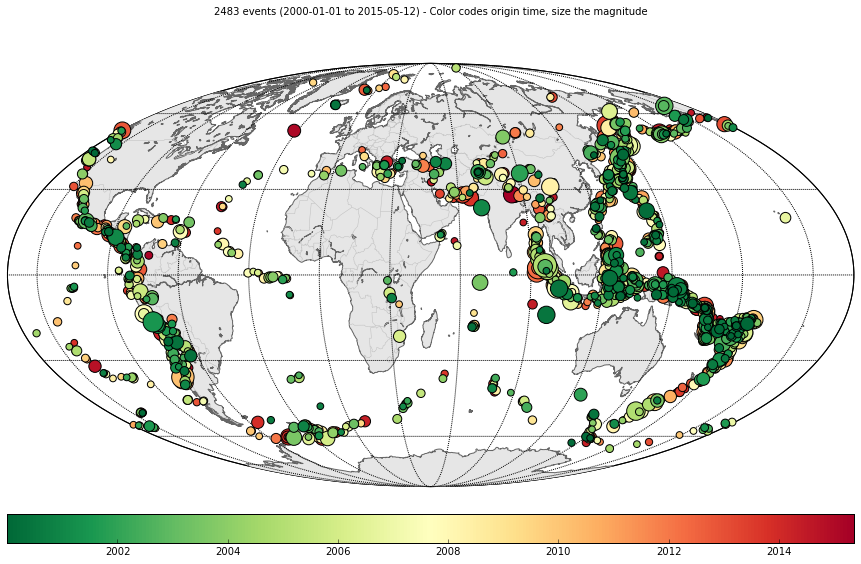

In [12]:
fig = glob_ev.plot(color='date')